# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# !! IMPORTANT: Restart the Kernel after running this cell !!

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 138 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 36.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 28.5 MB/s eta 0:00:01
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FloatProgress
import torchvision.models as models
from time import time

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transform = transforms.Compose([torchvision.transforms.ToTensor()])
test_transform = transforms.Compose([torchvision.transforms.ToTensor()])

# Create training set and define training dataloader

# Training and Testing set
trainset = torchvision.datasets.MNIST(root="data", train=True, transform=train_transform, download=True)
testset = torchvision.datasets.MNIST(root="data", train=False, transform=test_transform, download=True)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 16
num_workers = 2

# Training and Testing dataoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Label Mapping

In [4]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [125]:
# Loading test data

tests = enumerate(testloader)
batch_idx, (images, labels) = next(tests)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**I chose to only use ToTensor() transform and not additional transforms because the ToTensor() transform normalizes the images between [0,1] without any additional normalization or preprocessing.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [133]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

6


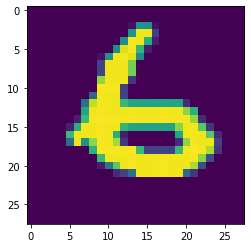

6


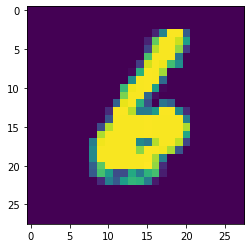

0


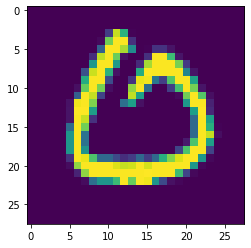

5


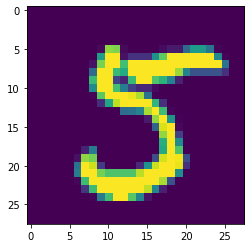

4


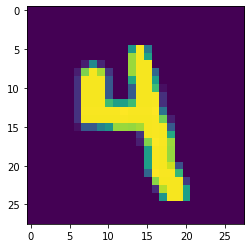

In [134]:
show5(trainloader)

## Dataset Exploration II

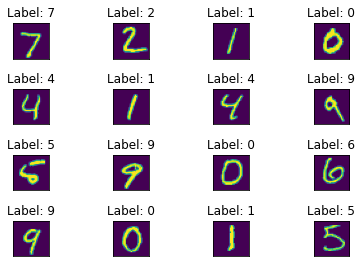

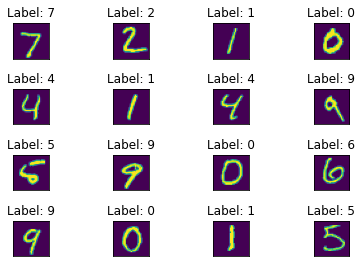

In [129]:
fig = plt.figure()
for i in range(batch_size):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0])
  plt.title("Label: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Dataset Exploration III

Batch


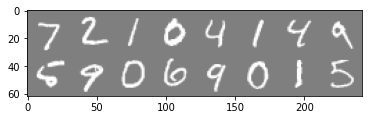

Batch Label
7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5    


In [130]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

print('Batch')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Batch Labels')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [11]:
class Network(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Network, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d()
        self.flatten = nn.Flatten()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        self.fc1 = nn.Linear(256, 150)
        self.fc2 = nn.Linear(150, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))

        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        
        # transform to logits
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [12]:
model = Network()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [141]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
print('=== Using {} for training ==='.format(device))

=== Using cpu for training ===


In [14]:
start_time = time()
train_loss_record = []
test_loss_record = []
accuracy_record = []

model.train()
epochs = 1
running_loss = 0
print_every = 5
for epoch in range(epochs):
    steps = 0
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                                       
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            train_loss_f = running_loss/print_every
            test_loss_f = test_loss/len(testloader)
            accuracy_f = accuracy/len(testloader) * 100
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}/{len(trainloader)}.. "
                  f"Train loss: {train_loss_f:.3f}.. "
                  f"Test loss: {test_loss_f:.3f}.. "
                  "Test accuracy: {:.3f}%".format(accuracy_f))
            
            # Record the train and test losses
            train_loss_record.append(train_loss_f)
            test_loss_record.append(test_loss_f)
            accuracy_record.append(accuracy_f)
            running_loss = 0
            model.train()

end_time = time()
total_time = end_time - start_time
print("\n[-] Total Elapsed time:",
      str(int((total_time/3600)))+":"+str(int((total_time%3600)/60))+":"
      +str(int((total_time%3600)%60)) )

Epoch 1/1.. Step 5/3750.. Train loss: 2.302.. Test loss: 2.291.. Test accuracy: 17.060%
Epoch 1/1.. Step 10/3750.. Train loss: 2.272.. Test loss: 2.282.. Test accuracy: 16.000%
Epoch 1/1.. Step 15/3750.. Train loss: 2.265.. Test loss: 2.271.. Test accuracy: 14.120%
Epoch 1/1.. Step 20/3750.. Train loss: 2.297.. Test loss: 2.255.. Test accuracy: 15.730%
Epoch 1/1.. Step 25/3750.. Train loss: 2.266.. Test loss: 2.234.. Test accuracy: 18.750%
Epoch 1/1.. Step 30/3750.. Train loss: 2.244.. Test loss: 2.207.. Test accuracy: 35.870%
Epoch 1/1.. Step 35/3750.. Train loss: 2.206.. Test loss: 2.163.. Test accuracy: 40.560%
Epoch 1/1.. Step 40/3750.. Train loss: 2.179.. Test loss: 2.110.. Test accuracy: 42.150%
Epoch 1/1.. Step 45/3750.. Train loss: 2.093.. Test loss: 2.026.. Test accuracy: 46.350%
Epoch 1/1.. Step 50/3750.. Train loss: 1.927.. Test loss: 1.918.. Test accuracy: 45.920%


KeyboardInterrupt: 

Plot the training loss (and validation loss/accuracy, if recorded).

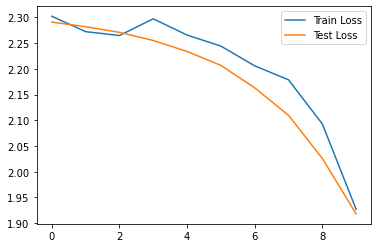

In [15]:
from matplotlib import pyplot as plt
plt.plot(train_loss_record, label='Train Loss')
plt.plot(test_loss_record,label='Test Loss')
plt.legend()
plt.show;

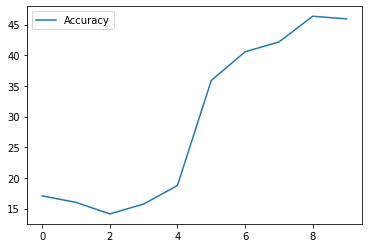

In [16]:
plt.plot(accuracy_record,label='Accuracy')
plt.legend()
plt.show;

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [17]:
test_loss = 0
accuracy = 0
model.eval()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print("Test loss: {:.3f}".format(test_loss/len(testloader)))
print("Test accuracy: {:.3f}%".format(accuracy/len(testloader) * 100))

# model.train()

Test loss: 1.786
Test accuracy: 46.130%


### Prediction

In [135]:
with torch.no_grad():
  output = model.forward(images)

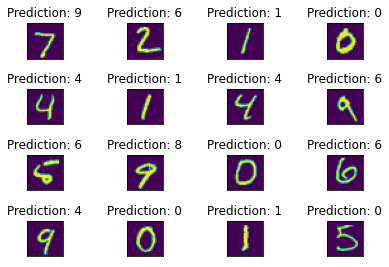

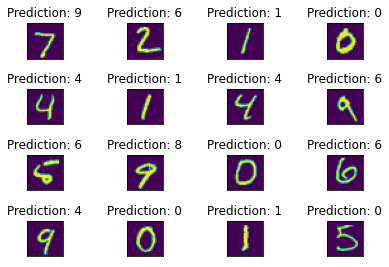

In [139]:
fig = plt.figure()
for i in range(batch_size):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0])
  plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [16]:
## YOUR CODE HERE ##


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
# DONE: Save the checkpoint
model.train()
model.cpu()
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion': 'NLLLoss'
}

torch.save(checkpoint, 'checkpoint.pth')
print('==== Save Complete ====')

## Loading your model
Using `torch.load`, load your model for future loading.

In [ ]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    """I took the below if else statement from the accepted answer of this stackoverflow question:
    https://stackoverflow.com/questions/55759311/runtimeerror-cuda-runtime-error-35-cuda-driver-version-is-insufficient-for
    """
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'

    checkpoint = torch.load(filepath, map_location=map_location)    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [ ]:
# Load the saved Model

model, optimizer = load_checkpoint('checkpoint.pth')
model

## Image Processing

In [117]:
def process_image(img):
    img = img.to(device)
    img = img.view(-1, 1, 28, 28)
    
    return img

## Class Prediction
Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-
) most probable classes. You'll want to calculate the class probabilities then find the 
 largest values.

To get the top 
 largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using class_to_idx which hopefully you added to the model or from an ImageFolder you used to load the data (see here). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> [7, 3, 4, 6, 5]
```

In [118]:
def predict(img, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    ''' 
    with torch.no_grad():
        logps = model.forward(img)
        ps = torch.exp(logps)
        probs, indexes = ps.topk(topk, dim=1)
    
    classes_p = []
    for index in indexes.numpy().flatten():
            classes_p.append(int(classes[index]))

    return probs, classes_p

## Sanity Checking
Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

Probabilities: [0.15133124589920044, 0.1448923498392105, 0.12930426001548767, 0.11271580308675766, 0.1066407710313797]
Classes: [1, 7, 9, 8, 4]


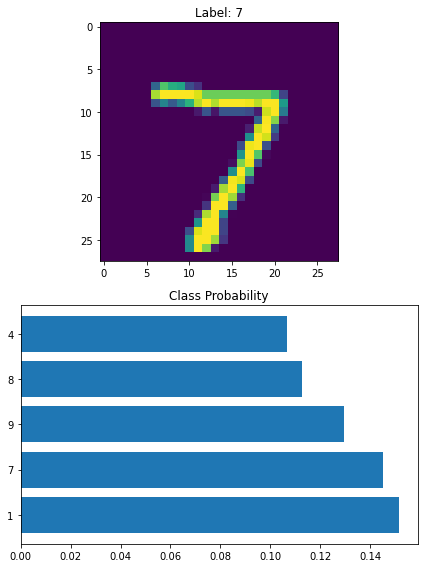

In [137]:
img = images[0][0]
image_label = labels[0]

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), nrows=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze())
ax1.set_title('Label: {}'.format(image_label))

image = process_image(img)

probs, classy = predict(image, model)
print('Probabilities:', probs.squeeze().tolist())
print('Classes:', classy)
ax2.barh(np.arange(5), probs.squeeze().tolist())
ax2.set_yticks(np.arange(5))
ax2.set_yticklabels(classy)
ax2.set_title('Class Probability')

plt.tight_layout()